In [1]:
import numpy as np
import scipy.stats as spst
import abel
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as spopt

# Gaussian distribution

In [2]:
Npart = 100

np.random.seed(1)
x = spst.truncnorm (a = -3, b = 3, loc = 0, scale = 1).rvs(size = Npart)/3

np.random.seed(2)
x_prime = spst.truncnorm (a = -3, b = 3, loc = 0, scale = 1).rvs(size = Npart)/3

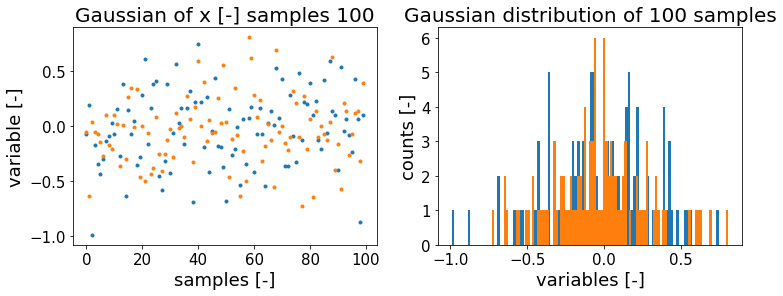

In [3]:
NumberBins = 100

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4) )

ax1.set_title("Gaussian of x [-] samples %i"%Npart, size = 20)
ax1.plot(x, ".")
ax1.plot(x_prime, ".")

ax1.set_xlabel("samples [-]", size = 18)
ax1.set_ylabel("variable [-]", size = 18)
ax1.tick_params(axis = "both", which = "major", labelsize = 15)

ax2.set_title("Gaussian distribution of %i samples"%Npart, size = 20)
[n_x, bins_x, patches_x] = ax2.hist(x, bins = NumberBins)
[n_xprime, bins_xprime, patches_xprime] = ax2.hist(x_prime, bins = NumberBins)

ax2.set_xlabel("variables [-]", size = 18)
ax2.set_ylabel("counts [-]", size = 18)
ax2.tick_params(axis = "both", which = "major", labelsize = 15)

In [4]:
radii = np.linspace(bins_x[np.argmax(n_x)], 1, NumberBins-np.argmax(n_x))

abel_gauss = abel.direct.direct_transform(n_x[np.argmax(n_x):], dr = np.diff(bins_x)[0], direction="Inverse", correction=True)

rho_r_r_gauss = radii*abel_gauss*2*np.pi

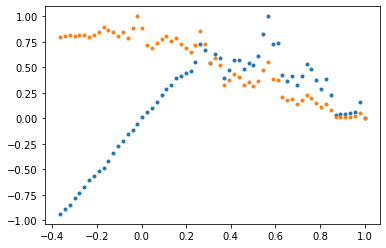

In [5]:
plt.plot(radii, rho_r_r_gauss/max(rho_r_r_gauss), ".")
plt.plot(radii, rho_r_r_gauss/radii/max(rho_r_r_gauss/radii), ".")

# Simulation chi distribution and pdf scraper losses

In [6]:
Npart = 100

#Chi distribution
r=np.linspace(0.00001,45,Npart)
chi_distro = spst.chi.pdf(r,2)*1.6

#scraper losses
epsilon_RMS = 1.36e-6
x_scraper = np.linspace(0, 45e-3, Npart)
scraper_losses = (1 + x_scraper/5.3/epsilon_RMS * np.exp(-0.5*(x_scraper)**2/5.3/epsilon_RMS))/max(1 + x_scraper/5.3/epsilon_RMS * np.exp(-0.5*(x_scraper)**2/5.3/epsilon_RMS))

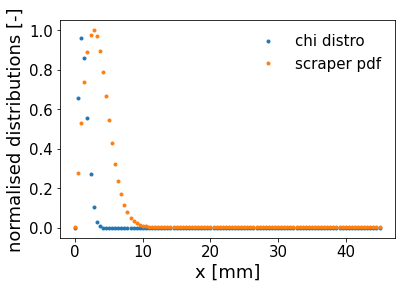

In [7]:
f, ax1 = plt.subplots(1, 1, figsize = (6, 4) )

ax1.plot(r, chi_distro, ".", label = "chi distro")
ax1.plot(x_scraper*1e3, scraper_losses, ".", label = "scraper pdf")

ax1.set_xlabel("x [mm]", size = 18)
ax1.set_ylabel("normalised distributions [-]", size = 18)
ax1.tick_params(axis = "both", which = "major", labelsize = 15)

ax1.legend(frameon = False, prop = {"size":15})

(0.0, 25.0)

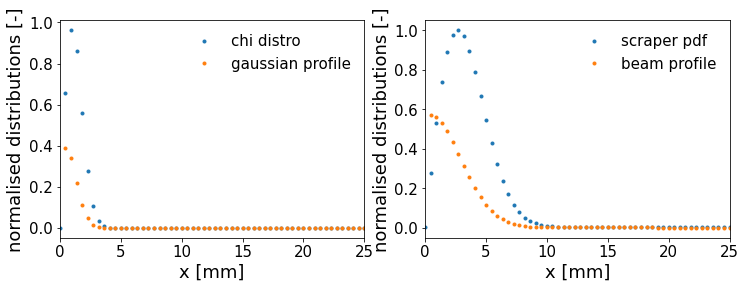

In [8]:
abel_chi_distro = abel.direct.direct_transform(chi_distro[1:]/2/np.pi/x_scraper[1:], dr = np.diff(x_scraper)[0], direction="forward", correction=True)

abel_scraper_losses = abel.direct.direct_transform(scraper_losses[1:]/2/np.pi/x_scraper[1:], dr = np.diff(x_scraper)[0], direction="forward", correction=True)


f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4) )

ax1.plot(r, chi_distro, ".", label = "chi distro")
ax1.plot(r[1:], abel_chi_distro, ".", label = "gaussian profile")

ax2.plot(x_scraper*1e3, scraper_losses, ".", label = "scraper pdf")
ax2.plot(r[1:], abel_scraper_losses, ".", label = "beam profile")

ax1.set_xlabel("x [mm]", size = 18)
ax1.set_ylabel("normalised distributions [-]", size = 18)
ax1.tick_params(axis = "both", which = "major", labelsize = 15)
ax1.legend(frameon = False, prop = {"size":15})
ax1.set_xlim([0, 25])

ax2.set_xlabel("x [mm]", size = 18)
ax2.set_ylabel("normalised distributions [-]", size = 18)
ax2.tick_params(axis = "both", which = "major", labelsize = 15)
ax2.legend(frameon = False, prop = {"size":15})
ax2.set_xlim([0, 25])

# Giulia Abel transform

In [30]:
def ForwardAbelTransform (*InputVariables, MinValueLosses, MinPointsInRisingEdge, MaximumOffset):
    if len(InputVariables) == 0:
        print("Error, you didn't put any input variable, please enter variables: scraper position and scintillator losses")
    elif len(InputVariables) == 1:
        print("Error, you didn't put all the needed variable, please enter variables BOTH: scraper position and scintillator losses")
    elif len(InputVariables) > 2:
        print("Error, too many input variables, please check input variables")
    elif len(InputVariables) == 2:
        print("Valid, all the needed variables have been inserted")
        
        
        ScraperPos = InputVariables[0]
        Losses = InputVariables [1] / max(InputVariables [1] )
        ##UPGRADE: find the first non-zero point
        Ind_LargerZero = np.where(Losses>MinValueLosses)[0][0]
        print("First non-zero point in losses", Ind_LargerZero)  
        if Ind_LargerZero == 0:
            CumulativeFunction = [] # Function where I collect the value of the integrals
        else:
            CumulativeFunction = np.ones(Ind_LargerZero) * np.nan
        ##UPGRADE: try to add oversampling if not enough points on the rising edge of the losses
        # In this configuration we are in the linear regime --> linear interpolation
        Ind_maxLosses = np.argmax(Losses) + MaximumOffset
        
        df = pd.DataFrame()
        df["x"] = ScraperPos
        df["y"] = Losses
        # start of oversampling
        plt.figure(figsize = (8,6))
        plt.plot(ScraperPos*1e3, Losses, ".b")
        while(len(Losses[Ind_LargerZero:Ind_maxLosses+1])<MinPointsInRisingEdge):
            df_OverSampling = pd.DataFrame()
            AdditionalPoint_x, AdditionalPoint_y = np.array([]), np.array([])

            if len(Losses[Ind_LargerZero:Ind_maxLosses+1])<MinPointsInRisingEdge:
                Ind_LargerZero = np.where(Losses>MinValueLosses)[0][0]
                Ind_maxLosses = np.argmax(Losses) + MaximumOffset
                for k, point in enumerate(Losses[Ind_LargerZero:Ind_maxLosses+1]):
                    AdditionalPoint_x = np.append(AdditionalPoint_x, ScraperPos[k+Ind_LargerZero] + (ScraperPos[(k+1)+Ind_LargerZero] - ScraperPos[k+Ind_LargerZero])/2)
                    AdditionalPoint_y = np.append(AdditionalPoint_y, Losses[k+Ind_LargerZero] + (Losses[(k+1)+Ind_LargerZero] - Losses[k+Ind_LargerZero])/2)
        
            df_OverSampling["x"] = AdditionalPoint_x
            df_OverSampling["y"] = AdditionalPoint_y
            df = pd.concat([df, df_OverSampling], ignore_index = True)
            df = df.sort_values(by=['x'])
                        
            ScraperPos = df.x.values
            Losses = df.y.values
            
            plt.plot(AdditionalPoint_x*1e3, AdditionalPoint_y, "xr")
            #plt.plot(AdditionalPoint_x[Ind_maxLosses], AdditionalPoint_y[Ind_maxLosses], "og")
            # plt.xlim([-1, max(ScraperPos)])
        plt.xlabel("x [mm]", size = 20)
        plt.ylabel("Losses [-]", size = 20)
        plt.tick_params(axis = "both", which = "major", labelsize = 15)
#         plt.savefig("AbelOutputPlot_MaxPoints_%i_MaxOffset_%i.pdf"%(MinPointsInRisingEdge, MaximumOffset))
        plt.xlim([-1, 30])
        # Compute dx for the Abel Transform, dx is centred w.r.t. the numerical/experimental point --> rectangular integral
        dx = np.zeros(len(ScraperPos))
        for i in range(len(ScraperPos)):
            if i == 0 or i == len(ScraperPos)-1:
                dx[0] = (ScraperPos[1]-ScraperPos[0])*0.5
                dx[-1] = (ScraperPos[-1]-ScraperPos[-2])*0.5
            else:
                dx[i] = ((ScraperPos[i+1] - ScraperPos[i])*0.5 + ScraperPos[i]) - ((ScraperPos[i] - ScraperPos[i-1])*0.5 + ScraperPos[i-1])
        # Rectangular integral definition
        for h, y in enumerate(ScraperPos[Ind_LargerZero:], start = Ind_LargerZero):
            Numerator = Losses[h+1:] * dx[h+1:]
            x = ScraperPos[h+1:]
            # Denominator = np.append(1, np.sqrt(x[1:]**2 - y**2))
            Denominator = np.sqrt((x-ScraperPos[Ind_LargerZero])**2 - (y-ScraperPos[Ind_LargerZero])**2)

            temp = Numerator/Denominator

            CumulativeFunction = np.append(CumulativeFunction, sum(temp)/np.pi)
        print(Ind_maxLosses)
        # calculation of the HWHM
        #plt.figure()
        #print("HFWM", ScraperPos[np.where(max(CumulativeFunction[Ind_LargerZero+1:])/2>CumulativeFunction[Ind_LargerZero+1:])[0][0]+Ind_LargerZero+1]*np.sqrt(2.*np.log(2))*1e-3)
        #plt.plot(ScraperPos[np.where(max(CumulativeFunction[Ind_LargerZero+1:])/2>CumulativeFunction[Ind_LargerZero+1:])[0][0]+Ind_LargerZero+1], CumulativeFunction[np.where(max(CumulativeFunction[Ind_LargerZero+1:])/2>CumulativeFunction[Ind_LargerZero+1:])[0][0]+Ind_LargerZero+1], "sg")
        #plt.plot(ScraperPos, CumulativeFunction, ".m")
        #plt.plot([0, 10], [max(CumulativeFunction[Ind_LargerZero+1:])/2, max(CumulativeFunction[Ind_LargerZero+1:])/2], "-r")
    return CumulativeFunction, Ind_LargerZero, ScraperPos

Valid, all the needed variables have been inserted
First non-zero point in losses 0
63
Valid, all the needed variables have been inserted
First non-zero point in losses 0
6
Valid, all the needed variables have been inserted
First non-zero point in losses 0
96


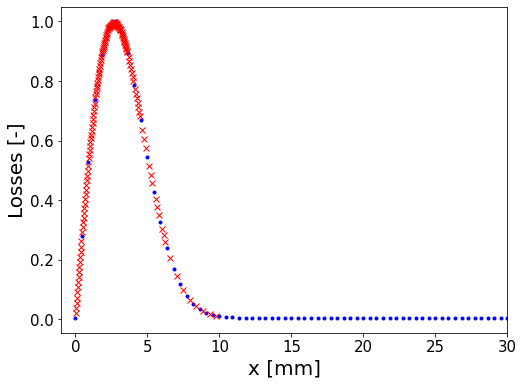

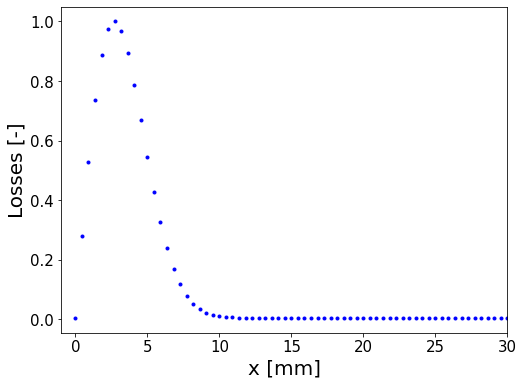

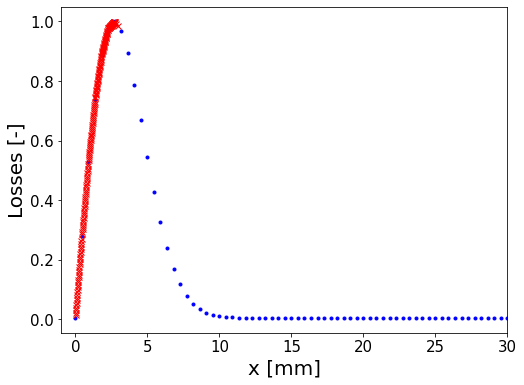

In [31]:
# AbelProfile, i_max, x_scraping = ForwardAbelTransform(*(x_scraper, scraper_losses))

GiuliaAbelTransform0, i_max0, x_scraper_OverSampled0 = ForwardAbelTransform(*(x_scraper, scraper_losses), MinValueLosses = 0., MinPointsInRisingEdge = 50, MaximumOffset = 15)
GiuliaAbelTransform1, i_max1, x_scraper_OverSampled1 = ForwardAbelTransform(*(x_scraper, scraper_losses), MinValueLosses = 0., MinPointsInRisingEdge = 1, MaximumOffset = 0)
GiuliaAbelTransform2, i_max2, x_scraper_OverSampled2 = ForwardAbelTransform(*(x_scraper, scraper_losses), MinValueLosses = 0., MinPointsInRisingEdge = 50, MaximumOffset = 0)

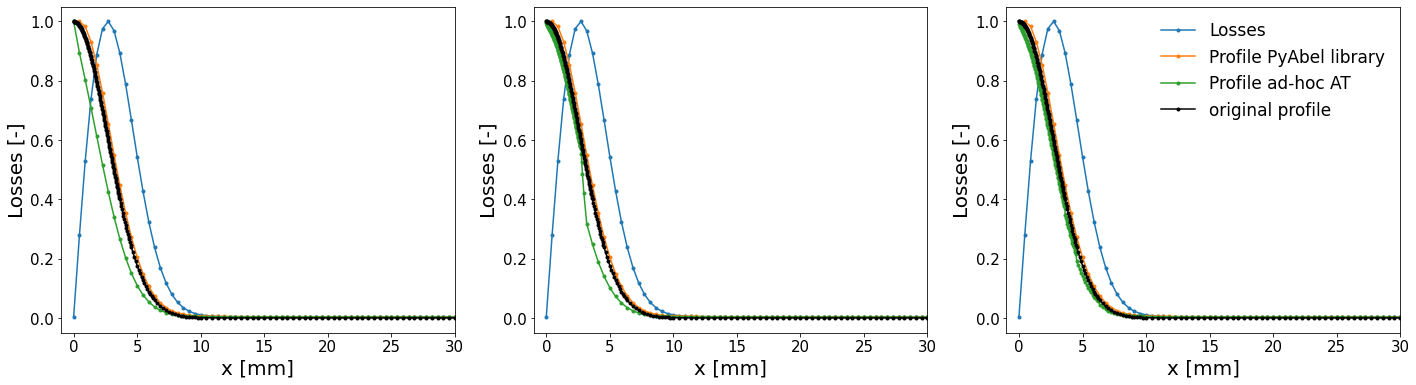

In [29]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (24,6), sharex = True, sharey = False)
# 
ax0.plot(x_scraper*1e3, scraper_losses, ".-", label = "Losses")
ax0.plot(r[1:], abel_scraper_losses/max(abel_scraper_losses), ".-", label = "Profile PyAbel library")
ax0.plot(x_scraper_OverSampled1*1e3,  GiuliaAbelTransform1/max(GiuliaAbelTransform1), ".-", label = "Profile ad-hoc AT")
# 
ax1.plot(x_scraper*1e3, scraper_losses, ".-", label = "Losses")
ax1.plot(r[1:], abel_scraper_losses/max(abel_scraper_losses), ".-", label = "Profile PyAbel library")
ax1.plot(x_scraper_OverSampled2*1e3,  GiuliaAbelTransform2/max(GiuliaAbelTransform2), ".-", label = "Profile ad-hoc AT ")
# 
ax2.plot(x_scraper*1e3, scraper_losses, ".-", label = "Losses")
ax2.plot(r[1:], abel_scraper_losses/max(abel_scraper_losses), ".-", label = "Profile PyAbel library")
ax2.plot(x_scraper_OverSampled0*1e3,  GiuliaAbelTransform0/max(GiuliaAbelTransform0), ".-", label = "Profile ad-hoc AT")

ax2.legend(frameon = False, prop = {"size":17})

gauss_function = 1/np.sqrt(2.*np.pi)/np.sqrt(epsilon_RMS*5.3)*np.exp(-0.5*x_scraper_OverSampled0**2/(epsilon_RMS*5.3))
ax0.plot(x_scraper_OverSampled0*1e3,  gauss_function/max(gauss_function), ".-k", label = "original profile")
ax1.plot(x_scraper_OverSampled0*1e3,  gauss_function/max(gauss_function), ".-k", label = "original profile")
ax2.plot(x_scraper_OverSampled0*1e3,  gauss_function/max(gauss_function), ".-k", label = "original profile")

ax2.legend(frameon = False, prop = {"size":17})

ax0.set_ylabel("Losses [-]", size = 20)
ax0.set_xlabel("x [mm]", size = 20)
ax0.tick_params(axis = "both", which = "major", labelsize = 15)

ax1.set_ylabel("Losses [-]", size = 20)
ax1.set_xlabel("x [mm]", size = 20)
ax1.tick_params(axis = "both", which = "major", labelsize = 15)

ax2.set_xlabel("x [mm]", size = 20)
ax2.set_ylabel("Losses [-]", size = 20)
ax2.tick_params(axis = "both", which = "major", labelsize = 15)
ax2.set_xlim([-1, 30])

f.savefig("ComparisonPyAbel_Abel_OriginalProfile.pdf", bbox_inches='tight')

# Fit PyAbel and Giulia beam profile to a Gaussian to check if I get back the same value of beam width

In [12]:
def GaussianCurve (x, x_0, ampl, x_mean, sigma):
    y = x_0 + ampl * 1/np.sqrt(2.*np.pi)/sigma * np.exp( -0.5 * (x - x_mean)**2 / sigma**2)
    return y

In [13]:
opt_coeff, opt_covar = spopt.curve_fit(GaussianCurve, r[1:], abel_scraper_losses)
print("PyAbel library")
print(opt_coeff, np.sqrt(opt_covar[0][0]), np.sqrt(opt_covar[1][1]), np.sqrt(opt_covar[2][2]))
print(opt_coeff[-1]**2/5.3, (opt_coeff[-1]**2/5.3-epsilon_RMS*1e6)/(epsilon_RMS*1e6)*100)

opt_coeff, opt_covar = spopt.curve_fit(GaussianCurve, x_scraping*1e3, AbelProfile)
print("Home-made Abel transform")
print(opt_coeff, np.sqrt(opt_covar[0][0]), np.sqrt(opt_covar[1][1]), np.sqrt(opt_covar[2][2]))
print(opt_coeff[-1]**2/5.3, (opt_coeff[-1]**2/5.3-epsilon_RMS*1e6)/(epsilon_RMS*1e6)*100)

PyAbel library
[1.69321042e-03 3.77115233e+00 3.00177630e-01 2.62169806e+00] 0.00010902199278623537 0.016277993621304228 0.012913652845657157
1.2968491925074332 -4.643441727394605


NameError: name 'x_scraping' is not defined

# Move losses profile in such a way that the first non-zero point is located at X>0

Valid, all the needed variables have been inserted
First non-zero point in losses 1
6
Valid, all the needed variables have been inserted
First non-zero point in losses 11
16
Valid, all the needed variables have been inserted
First non-zero point in losses 51
56
Valid, all the needed variables have been inserted
First non-zero point in losses 101
106


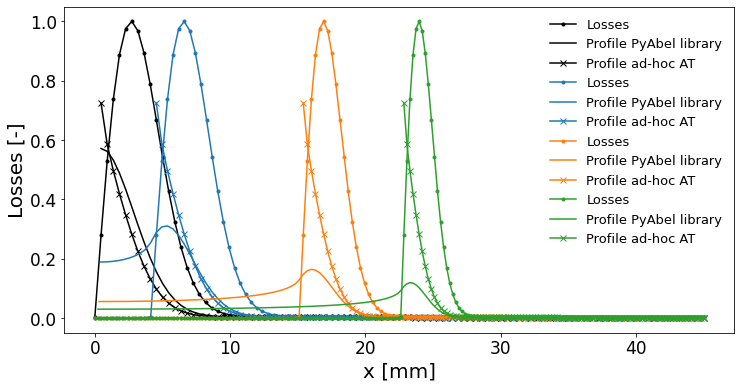

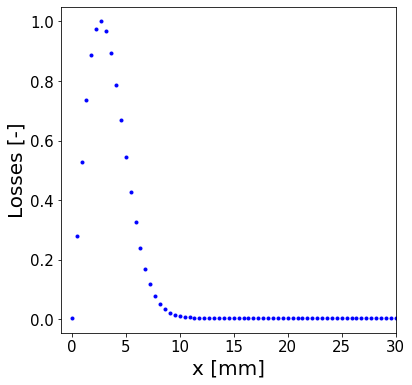

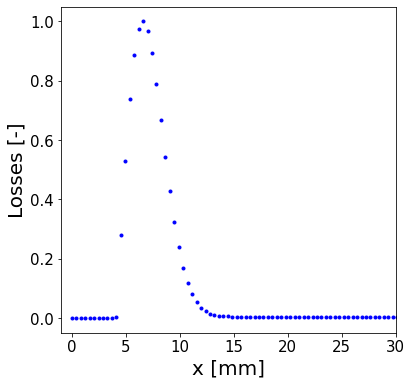

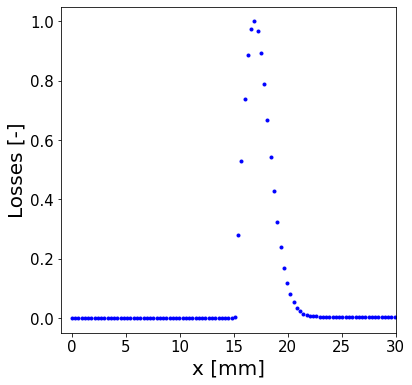

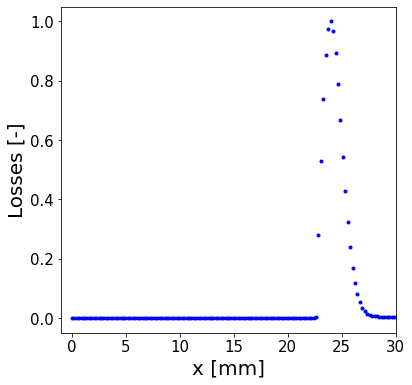

In [23]:
colorlist = ["k", "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

f, ax2 = plt.subplots(1, 1, figsize = (12,6))
LongData = [0, 1000, 5000, 10000]#[0, 100, 500, 1000, 2500, 5000]
ShortData = [0, 10, 50, 100]#[0, 1, 5, 10, 25, 50]
for i, shift in enumerate(ShortData):

    ShiftedLosses = np.append(np.zeros(np.abs(shift)), scraper_losses)
    x_shifted = np.linspace(0, 45e-3, len(ShiftedLosses))
#########
    abel_scraper_losses_shifted = abel.direct.direct_transform(ShiftedLosses[1:]/2/np.pi/x_shifted[1:], dr = np.diff(x_shifted)[0], direction="forward", correction=True)
#######
    Giulia_Abel, i_max, x_scraping = ForwardAbelTransform(*(x_shifted, ShiftedLosses), MinValueLosses = 0.01, MinPointsInRisingEdge = 1, MaximumOffset = 0)
 #######   
    ax2.plot(x_shifted*1e3, ShiftedLosses, ".-", color = colorlist[i], label = "Losses")
    ax2.plot(x_shifted[1:]*1e3, abel_scraper_losses_shifted, "-", color = colorlist[i], label = "Profile PyAbel library")
    ax2.plot(x_scraping*1e3,  Giulia_Abel, "x-", color = colorlist[i], label = "Profile ad-hoc AT")

ax2.legend(frameon = False, prop = {"size":13})
ax2.set_xlabel("x [mm]", size = 20)
ax2.set_ylabel("Losses [-]", size = 20)
ax2.tick_params(axis = "both", which = "major", labelsize = 17)